In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from exnn import xNN

## Simulation Settings

In [2]:
def simu_loader(generator, datanum, testnum, noise_sigma):
    def wrapper(rand_seed=0):
        return generator(datanum, testnum=testnum, noise_sigma=noise_sigma, rand_seed=rand_seed)
    return wrapper

def mse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.mean((pred - label)**2)


def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def data_generator1(datanum, testnum=10000, noise_sigma=1, rand_seed=0):
    
    corr = 0.5
    np.random.seed(rand_seed)
    proj_matrix = np.zeros((10, 4))
    proj_matrix[:7, 0] = np.array([1,0,0,0,0,0,0])
    proj_matrix[:7, 1] = np.array([0,1,0,0,0,0,0])
    proj_matrix[:7, 2] = np.array([0,0,0.5,0.5,0,0,0])
    proj_matrix[:7, 3] = np.array([0,0,0,0,0.2,0.3,0.5])
    u = np.random.uniform(-1, 1, [datanum + testnum, 1])
    t = np.sqrt(corr / (1 - corr))
    x = np.zeros((datanum + testnum, 10))
    for i in range(10):
        x[:, i:i + 1] = (np.random.uniform(-1, 1, [datanum + testnum, 1]) + t * u) / (1 + t)

    y = np.reshape(2 * np.dot(x, proj_matrix[:, 0]) + 0.2 * np.exp(-4 * np.dot(x, proj_matrix[:, 1])) + \
                   3 * (np.dot(x, proj_matrix[:, 2]))**2 + 2.5 * np.sin(np.pi * np.dot(x, proj_matrix[:, 3])), [-1, 1]) + \
              noise_sigma * np.random.normal(0, 1, [datanum + testnum, 1])
    
    task_type = "Regression"
    meta_info = {"X1":{"type":"continuous"},
             "X2":{"type":"continuous"},
             "X3":{"type":"continuous"},
             "X4":{"type":"continuous"},
             "X5":{"type":"continuous"},
             "X6":{"type":"continuous"},
             "X7":{"type":"continuous"},
             "X8":{"type":"continuous"},
             "X9":{"type":"continuous"},
             "X10":{"type":"continuous"},
             "Y":{"type":"target"}}
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == "target":
            sy = MinMaxScaler((-1, 1))
            y = sy.fit_transform(y)
            meta_info[key]["scaler"] = sy
        elif item['type'] == "categorical":
            enc = OrdinalEncoder()
            enc.fit(x[:,[i]])
            ordinal_feature = enc.transform(x[:,[i]])
            x[:,[i]] = ordinal_feature
            meta_info[key]["values"] = enc.categories_[0].tolist()
        else:
            sx = MinMaxScaler((-1, 1))
            x[:,[i]] = sx.fit_transform(x[:,[i]])
            meta_info[key]["scaler"] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=testnum, random_state=rand_seed)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(mse, sy)

train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=10000, testnum=10000,
                                                                                     noise_sigma=1, rand_seed=0)

## Grid Search in Parallel

In [3]:
def xnn_repeat(folder, name, data_generator,
               subnet_num=10,
               subnet_arch=[10, 6],
               task="Regression",
               activation_func=tf.tanh,
               lr_bp=0.001,
               l1_proj=0.001,
               l1_subnet=0.001,
               batch_size=1000,
               training_epochs=5000,
               tuning_epochs=500,
               beta_threshold=0.05,
               verbose=False,
               val_ratio=0.2,
               early_stop_thres=1000,
               rand_seed=0):

    train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator(rand_seed)

    input_num = train_x.shape[1]
    model = xNN(meta_info=meta_info,
                subnet_num=min(10, input_num),
                subnet_arch=subnet_arch,
                task_type=task_type,
                activation_func=tf.tanh,
                batch_size=min(batch_size, int(train_x.shape[0] * 0.2)),
                training_epochs=training_epochs,
                lr_bp=lr_bp,
                beta_threshold=beta_threshold,
                tuning_epochs=tuning_epochs,
                l1_proj=l1_proj,
                l1_subnet=l1_subnet,
                verbose=verbose,
                val_ratio=val_ratio,
                early_stop_thres=early_stop_thres)
    model.fit(train_x, train_y)
    model.visualize(folder=folder,
                    name=name,
                    save_png=True,
                    save_eps=True)

    tr_x = train_x[model.tr_idx]
    tr_y = train_y[model.tr_idx]
    val_x = train_x[model.val_idx]
    val_y = train_y[model.val_idx]

    pred_train = model.predict(tr_x)
    pred_val = model.predict(val_x)
    pred_test = model.predict(test_x)

    stat = np.hstack([np.round(get_metric(tr_y, pred_train), 5),\
                np.round(get_metric(val_y, pred_val), 5),\
                np.round(get_metric(test_y, pred_test), 5)])
    res_stat = pd.DataFrame(stat.reshape([1, -1]), columns=['train_metric', 'val_metric', "test_metric"])
    res_stat["Subnet_Number"] = min(input_num, 10)
    res_stat["lr_BP"] = lr_bp
    res_stat["L1_Penalty_Proj"] = l1_proj
    res_stat["L1_Penalty_Subnet"] = l1_subnet
    res_stat["Training_Epochs"] = training_epochs
    return res_stat

In [4]:
cv_results = Parallel(n_jobs=25)(delayed(xnn_repeat)(folder="./results/S1_xnn/",
                      name=str(i + 1).zfill(2) + "_" + str(j + 1).zfill(2),
                      data_generator=simu_loader(data_generator1, 10000, 10000, 1),
                      task=task_type,
                      subnet_arch=[10, 6],
                      beta_threshold=0.05,
                      l1_proj=10**(-2 - i*0.5),
                      l1_subnet=10**(-2 - j*0.5),
                      training_epochs=10000,
                      lr_bp=0.001,
                      batch_size=1000,
                      early_stop_thres=500,
                      tuning_epochs=100,
                      rand_seed=0) for i in range(5) for j in range(5) for k in [1])
sosxnn_stat_all = pd.concat(cv_results)
sosxnn_stat_all.sort_values("val_metric")

,train_metric,val_metric,test_metric,Subnet_Number,lr_BP,L1_Penalty_Proj,L1_Penalty_Subnet,Training_Epochs
0,0.99941,1.02802,0.99131,10,0.001,0.000100,0.000100,10000
0,1.00006,1.02963,0.99138,10,0.001,0.000100,0.000316,10000
0,1.00077,1.03102,0.99087,10,0.001,0.000100,0.001000,10000
0,1.00694,1.03506,0.99288,10,0.001,0.000316,0.000100,10000
0,1.00873,1.03596,0.99593,10,0.001,0.000316,0.000316,10000
0,1.01114,1.03796,0.99696,10,0.001,0.000316,0.001000,10000
0,1.08260,1.11844,1.06516,10,0.001,0.003162,0.001000,10000
0,1.08183,1.12035,1.06763,10,0.001,0.003162,0.000100,10000
0,1.08229,1.12094,1.06543,10,0.001,0.001000,0.001000,10000
0,1.08268,1.12336,1.06828,10,0.001,0.003162,0.000316,10000


In [5]:
best_l1_prob = sosxnn_stat_all.sort_values("val_metric").loc[:,"L1_Penalty_Proj"].iloc[0]
best_l1_subnet = sosxnn_stat_all.sort_values("val_metric").loc[:,"L1_Penalty_Subnet"].iloc[0]

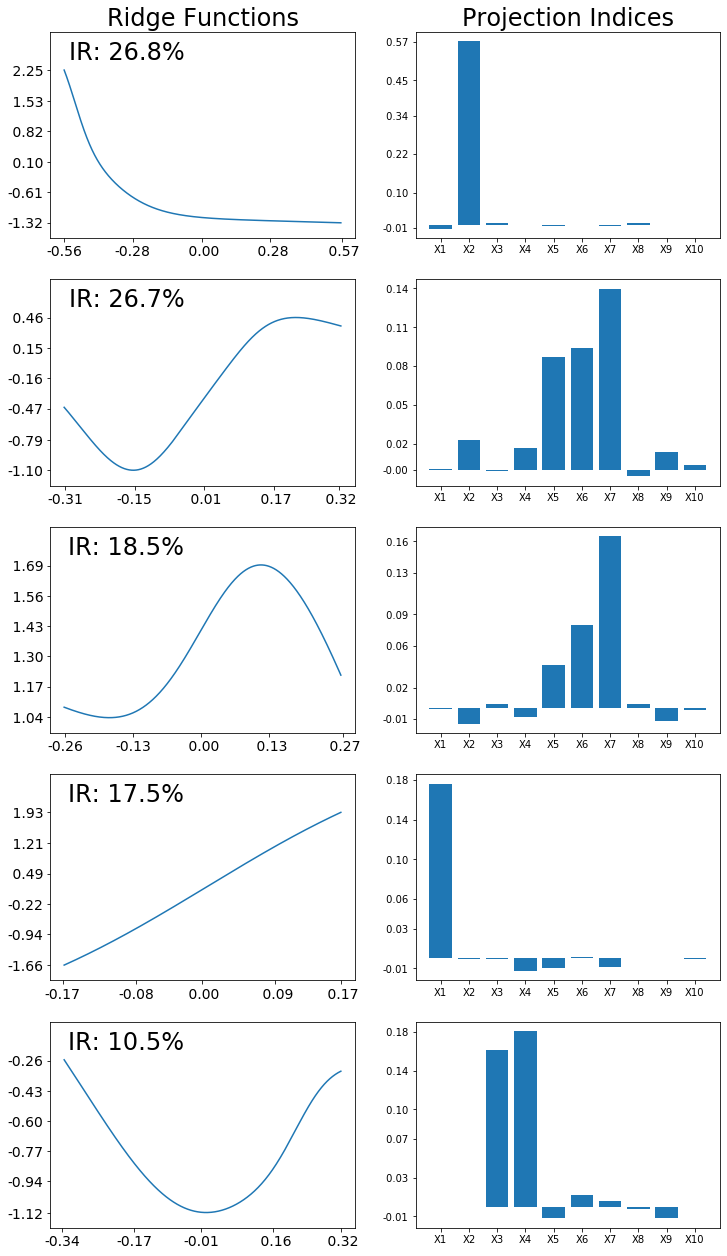

In [6]:
model = xNN(meta_info=meta_info,
               subnet_num=10,
               subnet_arch=[10, 6],
               task_type=task_type,
               activation_func=tf.tanh,
               batch_size=min(1000, int(train_x.shape[0] * 0.2)),
               training_epochs=10000,
               lr_bp=0.001,
               beta_threshold=0.05,
               tuning_epochs=100,
               l1_proj=best_l1_prob,
               l1_subnet=best_l1_subnet,
               verbose=False,
               val_ratio=0.2,
               early_stop_thres=500)
model.fit(train_x, train_y)
model.visualize("./", "xnn_demo")

In [7]:
tr_pred = model.predict(train_x[model.tr_idx]) 
val_pred = model.predict(train_x[model.val_idx]) 
pred_test = model.predict(test_x)

mse_stat = np.hstack([np.round(get_metric(train_y[model.tr_idx], tr_pred), 5),\
                      np.round(get_metric(train_y[model.val_idx], val_pred),5),\
                      np.round(get_metric(test_y, pred_test),5)])
print(mse_stat)

[0.99941 1.02802 0.99131]
